In [1]:
# Reference:
#    https://peterroelants.github.io/posts/gaussian-process-kernels/
#    https://distill.pub/2019/visual-exploration-gaussian-processes/
#    http://gregorygundersen.com/blog/2019/06/27/gp-regression/
#
import numpy as np
from numpy.linalg import inv, det, cholesky
from numpy.linalg import solve as backsolve
np.set_printoptions(precision=3,suppress=True)
from sklearn.metrics import mean_squared_error

import jax
from jax import grad, jit, vmap, device_put
import jax.numpy as jnp
import jax.numpy.linalg as jnp_linalg
from jax.experimental import optimizers
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, cov_se2, cov_rq, cov_pe, LookupKernel, normalize_K)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd


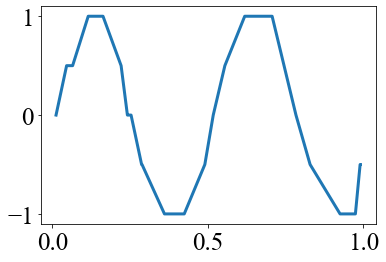

In [5]:

X0 = np.sort(np.random.rand(int(n_train*task0_n_ratio), 1), axis=0)
X1 = np.sort(np.random.rand(n_train-len(X0), 1)*.5, axis=0)
X_train = np.vstack((np.hstack((X0, np.zeros_like(X0))),
                     np.hstack((X1, np.ones_like(X1)))))

f0 = lambda X: np.round(np.sin(12*X)*2)/2
f1 = lambda X: np.sin(12*X + shift)
fs = [f0,f1]
Y0 = f0(X0) + np.random.randn(*X0.shape)*σns[0]
Y1 = f1(X1) + np.random.randn(*X1.shape)*σns[1]
y_train = np.vstack((Y0,Y1))

plt.plot(X0, f0(X0))

In [ ]:
## Parameters

M = 2
n_train = 100
n_test = 50
ylim = (-3,3)
xlim = (-.2,1.2)
σns = [.03, .1]
ℓ = .2
mode = 'stgp'
mode = 'mtgp'
mode = 'amtgp'
lr = .0005
num_steps = 200
verbose = True
scale = 12
        
def log_func(i, f, params):
    if verbose:
        print(tabulate([[f(params)]+[x.item() if x.size==1 else x for x in list(params.values())]],
                       tablefmt="plain",
                       floatfmt=".3f",
                       headers=['loss']+list(params.keys()) if i == 0 else ()))


## Plotting

colors_b = [cmap(.1), cmap(.3)]
colors_r = [cmap(.9), cmap(.7)]
mses = {}
modes = ['stgp', 'mtgp', 'amtgp']
shifts = [0., .1, .2, .3, .4, .5, 1.]
task0_n_ratio = 2/3

# modes = ['stgp', 'mtgp', 'amtgp']
# shifts = [0.]
# task0_n_ratio = 3/4

for si, shift in enumerate(shifts): # 
    
    nrows = len(modes)
    gridspec_kw = {'width_ratios': [2, 1], 'height_ratios': [1 for _ in range(nrows)]}
    fig, axs = plt.subplots(nrows, 2, gridspec_kw=gridspec_kw)
    fig.set_size_inches(15, 5*nrows)


    for i, mode in enumerate(modes):
        
        print(shift,mode)

        ## Data
        np.random.seed(0)

        B = jnp.eye(M)

        X0 = np.sort(np.random.rand(int(n_train*task0_n_ratio), 1), axis=0)
        X1 = np.sort(np.random.rand(n_train-len(X0), 1)*.5, axis=0)
        X_train = np.vstack((np.hstack((X0, np.zeros_like(X0))),
                             np.hstack((X1, np.ones_like(X1)))))

        f0 = lambda X: np.sin(scale*X)
        f1 = lambda X: np.sin(scale*X + shift)
        fs = [f0,f1]
        Y0 = f0(X0) + np.random.randn(*X0.shape)*σns[0]
        Y1 = f1(X1) + np.random.randn(*X1.shape)*σns[1]
        y_train = np.vstack((Y0,Y1))

        X_test = np.vstack((np.tile(np.linspace(xlim[0], xlim[1], n_test), M),
                            np.hstack([t*np.ones(n_test) for t in range(M)]))).T


        ## Training

        def mtgp_k(XT, XTp, logℓ, B):
            X, Xp = XT[:,0], XTp[:,0]
            Kx = cov_se2(X, Xp, logℓ=logℓ)
            T, Tp = np.asarray(XT[:,1], np.int), np.asarray(XTp[:,1], np.int)
            Kt = LookupKernel(T, Tp, B)
            K = Kx*Kt
            return K

        def mtgp_k_soft(XY, XYp, logℓx, logℓy, logσy):
            X, Xp = XY[:,0], XYp[:,0]
            Kx = cov_se2(X, Xp, logℓ=logℓx)
            Y, Yp = XY[:,1], XYp[:,1]
            Ky = cov_se2(Y, Yp, logℓ=logℓy, logσ=logσy)
            K = Kx*Ky
            return K

        if mode == 'stgp':
            def nmll(params):
                k = lambda X, Y: mtgp_k(X, Y, params['logℓ'], B)
                μ, Σ, mll = gp_regression_chol(
                    X_train, y_train, X_test, k, logsn=params['logsn'])
                return -mll
            params = {'logℓ': jnp.log(1.),
                      'logsn': jnp.log(.1*jnp.ones(M))}
            res = run_sgd(nmll, params, lr=lr, num_steps=num_steps, log_func=None)
            logℓ, logsn = res['logℓ'].item(), res['logsn']
            ℓ, σn = jnp.exp(logℓ), jnp.exp(logsn)
        if mode == 'mtgp':
            def nmll(params):
                L = jnp.exp(params['logL'])
                B = L@L.T
                k = lambda X, Y: mtgp_k(X, Y, params['logℓ'], B)
                μ, Σ, mll = gp_regression_chol(
                    X_train, y_train, X_test, k, logsn=params['logsn'])
                return -mll
            params = {'logℓ': jnp.log(1.),
                      'logsn': jnp.log(.1*jnp.ones(M)),
                      'logL': jnp.log(jnp.array(np.eye(M))*shift + np.random.rand(M,M) )}
            res = run_sgd(nmll, params, lr=lr, num_steps=num_steps, log_func=None)
            logℓ, logsn = res['logℓ'].item(), res['logsn']
            ℓ, σn = jnp.exp(logℓ), jnp.exp(logsn)
            L = jnp.exp(params['logL'])
            B = L@L.T
        if mode == 'amtgp':
            # Train independently on auxiliary task 0
            #
            I = X_train[:,1] == 0
            X_train_aux = X_train[I,0]
            y_train_aux = y_train[I]
            def nmll(params):
                k = lambda X, Y: cov_se2(X, Y, logℓ=params['logℓ'])
                μ, Σ, mll = gp_regression_chol(
                    X_train_aux, y_train_aux, X_test, k, logsn=params['logsn'])
                return -mll
            params = {'logℓ': jnp.log(1.),'logsn': jnp.log(.1)}
            res = run_sgd(nmll, params, lr=lr, num_steps=num_steps, log_func=None)
            logℓ0, logsn0 = res['logℓ'].item(), res['logsn']
            ℓ0, σn0 = jnp.exp(logℓ0), jnp.exp(logsn0)

            # Predict at task=1's location
            I = X_train[:,1]==1
            k = lambda X, Y: cov_se2(X, Y, logℓ=logℓ0)
            μ, _, _ = gp_regression_chol(X_train_aux, y_train_aux, X_train[I,0], k, logsn0)
            # (X1, Y0μ)
            X_train_main = np.vstack((X_train[I,0], μ.squeeze())).T
            y_train_main = y_train[I]
            def nmll(params):
                k = lambda X, Y: mtgp_k_soft(X, Y, params['logℓx'], params['logℓy'], params['logσy'])
                μ, Σ, mll = gp_regression_chol(
                    X_train_main, y_train_main, X_test, k, logsn=params['logsn'])
                return -mll
            params = {'logℓx': jnp.log(1.),
                      'logℓy': jnp.log(1.),
                      'logσy': jnp.log(1.),
                      'logsn': jnp.log(.1)}
            res = run_sgd(nmll, params, lr=lr, num_steps=num_steps, log_func=None)
            logℓx, logℓy, logsn1, logσy = res['logℓx'].item(), res['logℓy'].item(), res['logsn'].item(), res['logσy'].item()
            ℓx, ℓy, σn1, σy = jnp.exp(logℓx), np.exp(logℓy), jnp.exp(logsn1), jnp.exp(logσy)


        ## Plotting

        if mode in ['stgp', 'mtgp']:
            ax = axs[i, 0]
            k = lambda X, Y: mtgp_k(X, Y, logℓ, B)
            μ, Σ, mll = gp_regression_chol(X_train, y_train, X_test, k, logsn)
            std = np.expand_dims(np.sqrt(np.diag(Σ)), 1)

            for t in range(M):
                # task-specific mll
                I = X_test[:,1] == t
                # posterior predictive distribution
                X_test_, μ_, std_ = X_test[I,0].squeeze(), μ[I].squeeze(), std[I].squeeze()
                ax.plot(X_test_, μ_, color=colors_b[t], lw=2)
                ax.fill_between(X_test_, μ_-2*std_, μ_+2*std_, alpha=.2, color=colors_b[t])
                # generating function for main task
                if t == 1:
                    ax.plot(X_test_, fs[t](X_test_), color='k', linestyle='dashed', linewidth=1)

                mse = mean_squared_error(μ[I], fs[t](X_test[I,0]))
                if t==1: mses[(shift,mode)]=mse
                # train data points
                I = X_train[:,1] == t
                ax.scatter(X_train[I,0], y_train[I],
                           marker='x', color=colors_r[t], s=50,
                           label=f'Task {t}'+' ($\sigma_n$'+f'={σn[t]:.2f}, '+'$mse$'+f'={mse:.3f})')

            ax.grid()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_ylabel('$'+f'{mode}'+'}$')
            ax.legend(loc='upper left', fontsize=15)
            title = '$\ell$'+f'={ℓ:.2f}'+ \
                ' $B_{01}/B_{00}$'+f'={B[0,1]*2/(B[0,0]+B[1,1]):.2f}'+ \
                ' $-mll$'+f'={-mll:.2f}'
            ax.set_title(title, fontsize=30)
            


            ax = axs[i, 1]
            XX = np.vstack((X_train, X_test[X_test[:,1]==1]))
            K = k(XX, XX)
            im = ax.imshow(normalize_K(K), cmap=cmap)
            fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
            ax.set_title('$K(X_{train}, X_{test@1})$')


        if mode == 'amtgp':
            ax = axs[i, 0]
            # Predict at task=1's test location
            I = X_test[:,1]==1
            k = lambda X, Y: cov_se2(X, Y, logℓ=logℓ0)
            Y0μ, Σ, _ = gp_regression_chol(X_train_aux, y_train_aux, X_test[I,0], k, logsn0)
            # Use posterior mean of task=0 regressor as additional input to task=1 regressor
            X_test_main = np.vstack((X_test[I,0], Y0μ.squeeze())).T
            k = lambda X, Y: mtgp_k_soft(X, Y, logℓx, logℓy, logσy)
            Y1μ, Σ, mll = gp_regression_chol(X_train_main, y_train_main, X_test_main, k, logsn1)
            Y1std = np.expand_dims(np.sqrt(np.diag(Σ)), 1).squeeze()
            Y1μ = Y1μ.squeeze()

            t = 1
            ax.plot(X_test_main[:,0], Y1μ, color=colors_b[t], lw=2)
            ax.fill_between(X_test_main[:,0], Y1μ-2*Y1std, Y1μ+2*Y1std, alpha=.2, color=colors_b[t])
            ax.plot(X_test_main[:,0], fs[t](X_test_main[:,0]), color='k', linestyle='dashed', linewidth=1)

            mse = mean_squared_error(Y1μ, fs[1](X_test[I,0]))
            mses[(shift, mode)] = mse
            I = X_train[:,1] == t
            ax.scatter(X_train[I,0], y_train[I],
                       marker='x', color=colors_r[t], s=50,
                       label=f'Task {t}'+' ($\sigma_n$'+f'={σn1:.2f}, '+'$mse$'+f'={mse:.3f})')

            ax.grid()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_ylabel('$'+f'{mode}'+'}$')
            ax.legend(loc='upper left', fontsize=15)
            title = '$\ell_x,\ell_y$'+f'={ℓx:.2f},{ℓy:.2f}'+' $\sigma_y$'+f'={σy:.2f}'+' $-mll_{1}$'+f'={-mll:.2f}'
            ax.set_title(title, fontsize=30)

            ax = axs[i, 1]
            XX = np.vstack((X_train_main, X_test_main))
            k = lambda X, Y: mtgp_k_soft(X, Y, logℓx, logℓy, logσy)
            K = k(XX, XX)
            im = ax.imshow(normalize_K(K), cmap=cmap)
            fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
            ax.set_title('$K(X_{train@1}, X_{test@1})$')


    fig.tight_layout()
    
#     plt_savefig(fig, f'summary/assets/plt_mtgp_coorperative.png')
#     plt_savefig(fig, f'summary/assets/plt_mtgp_competitive.png')
    plt_savefig(fig, f'summary/assets/plt_amtgp_shift={shift}_scale={scale}.png')




In [23]:
data = []
shifts = np.unique([x[0] for x in mses.keys()])
for s in shifts:
    data.append([s] + list([mses[(s,mode)] for mode in modes]))

print(tabulate(data, tablefmt='simple', headers=['shift']+modes, floatfmt='.3f'))

  shift    stgp    mtgp    amtgp
-------  ------  ------  -------
  0.000   0.917   0.105    0.050
  0.100   0.911   0.163    0.096
  0.200   0.892   0.078    0.388
  0.300   0.862   0.062    0.535
  0.400   0.822   0.068    0.551
  0.500   0.775   0.102    0.368
  1.000   0.490   0.340    0.332


In [ ]:
print(tabulate(data, tablefmt='latex', headers=['shift']+modes, floatfmt='.3f'))

In [ ]:

X0 = np.sort(np.random.rand(int(n_train*task0_n_ratio), 1), axis=0)
X1 = np.sort(np.random.rand(n_train-len(X0), 1)*.5, axis=0)
X_train = np.vstack((np.hstack((X0, np.zeros_like(X0))),
                     np.hstack((X1, np.ones_like(X1)))))

f0 = lambda X: np.round(np.sin(6*X)*2)/2
f1 = lambda X: np.sin(6*X + shift)
fs = [f0,f1]
Y0 = f0(X0) + np.random.randn(*X0.shape)*σns[0]
Y1 = f1(X1) + np.random.randn(*X1.shape)*σns[1]
y_train = np.vstack((Y0,Y1))

plt.scatter(X0, f0(X0))

In [18]:
# ratio=5/6

#    0.000 &  0.845 &  0.020 &   0.426 \\
#    0.100 &  0.983 &  0.013 &   0.187 \\
#    0.300 &  1.240 &  0.036 &   0.166 \\
#    0.500 &  1.440 &  0.136 &   0.287 \\
#    1.000 &  1.493 &  0.420 &   0.369 \\
#    1.500 &  0.923 &  0.362 &   0.629 \\
#    2.000 &  0.294 &  0.232 &   0.285 \\
    
# ratio=1/2
#    0.000 &  0.159 &  0.012 &   0.055 \\
#    0.100 &  0.150 &  0.009 &   0.105 \\
#    0.300 &  0.141 &  0.027 &   0.175 \\
#    0.500 &  0.141 &  0.034 &   0.167 \\
#    1.000 &  0.156 &  0.058 &   0.174 \\
#    1.500 &  0.140 &  0.044 &   0.173 \\
#    2.000 &  0.078 &  0.046 &   0.132 \\

# scale=12, ratio=2/3 n=100
# 


DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32)